# This code will train the model and save weights  using a data generator

First Import libraries

In [1]:
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define our Data Generator and other functions to be used later

In [3]:
from Data_Gen import DataGenerator 

In [4]:
test_image = np.load(r"C:\Users\UAB\Kidney-Segmentation-Jupyter\data\101934_1_96_L_20_M.npy")
test_label = np.load(r"C:\Users\UAB\Kidney-Segmentation-Jupyter\data\101934_1_96_L_20_K.npy")

In [5]:
test_image.shape

(512, 512)

In [6]:
test_label.shape
test_label.max()

1.0

In [7]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

Define the paths where images and segmentations are located. Gather into groups and arrange into a dictionary that can be split up for training, testing, and validation for the model

In [8]:
data_path = r"C:\Users\UAB\Kidney-Segmentation-Jupyter\data\\"

images = gather_set(data_path, '_M.')
labels = gather_set(data_path, '_K')
print(images[0:2], labels[0:2])


['101934_1_96_L_0_M.npy', '101934_1_96_L_10_M.npy'] ['101934_1_96_L_0_K.npy', '101934_1_96_L_10_K.npy']


In [9]:
test_img = np.load(data_path + images[1])
print(test_img.shape)
test_lab = np.load(data_path + labels[1])
print(test_lab.shape)


(512, 512)
(512, 512)


In [10]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [11]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(list(labels.keys()),train_size = 0.8)
partition = {'train':train, 'validation':val}

#print(partition)
#print(labels)

Create our data generators 

## Attempt expected 2 class

In [17]:
params = {'dim': (512,512),
          'batch_size': 30,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [18]:
X, y = training_generator[50]

In [19]:
print(X.shape)
print(y.shape)

(300, 512, 512, 1)
(300, 512, 512, 2)


## View output

(512, 512) 1.0 1.0


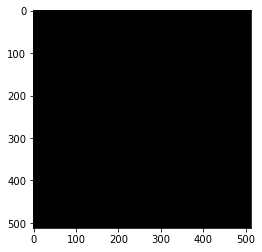

In [26]:
X_batch = y[200,:,:,:]
X_batch.shape
X_img = X_batch[:,:,0]
print(X_img.shape, X_img.max(), X_img.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

(512, 512) 1.0 1.0


<Figure size 432x288 with 0 Axes>

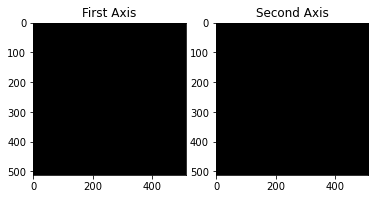

In [39]:
y_batch = y[20,:,:,:]
y_batch.shape
y_img_0 = y_batch[:,:,0]
y_img_1 = y_batch[:,:,1]
print(y_img_0.shape, y_img_0.max(), y_img_0.min())


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(y_img_0, cmap="gray")
axarr[0].title.set_text('First Axis')
axarr[1].imshow(y_img_1, cmap='gray')
axarr[1].title.set_text('Second Axis')

## Attempt with 1 class

In [41]:
params = {'dim': (512,512),
          'batch_size': 30,
          'n_classes': 1,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [43]:
X1, y1 = training_generator[20]
print(X1.shape)
print(y1.shape)

(30, 512, 512, 1)
(30, 512, 512, 1)


(512, 512) 0.0 0.0


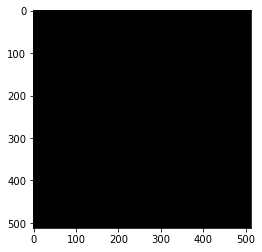

In [46]:
X_batch = X1[20,:,:,:]
X_batch.shape
X_img = X_batch[:,:,0]
print(X_img.shape, X_img.max(), X_img.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

Ensure dictionary is properly reading in images:

In [57]:
#print(partition['train'])
my_list = [i for i in partition.values()]
ID = my_list[0][20]
im_fname = 'data\\'+ID
im = np.load(im_fname)

(512, 512)


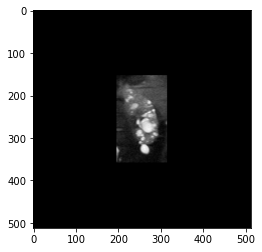

In [58]:
print(im.shape)
plt.imshow(im, cmap = 'gray')

data\101934_1_96_R_52_K.npy


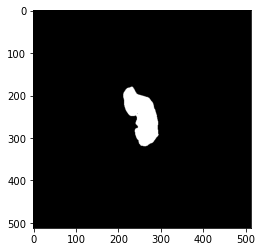

In [61]:
lbl_fname = im_fname.replace('M.npy', 'K.npy')
print(lbl_fname)
lbl = np.load(lbl_fname)
plt.imshow(lbl, cmap = 'gray')

In [85]:
z = np.zeros([1,512,512,1])
print(im.max(), im.shape)
#z[0, ...,0] = im[...,0] ### results in blank
z[0, ...,0] = im[...] ### here where I define the axis

print(z.shape)

96.0 (512, 512)
(1, 512, 512, 1)


(1, 512, 512)
(512, 512)


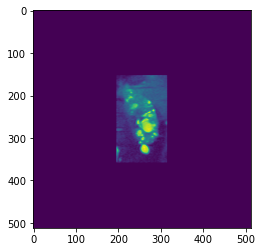

In [86]:
z_img = z[:,:,:,0]
print(z_img.shape)
z_disp = z_img[0,:,:]
print(z_disp.shape)
plt.imshow(z_disp)

In [87]:
print(z.max())

96.0


In [ ]:
#data generator updated attempt new generation


In [12]:
from Data_Gen import DataGenerator 

In [14]:
params = {'dim': (512,512),
          'batch_size': 30,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator_2 = DataGenerator(partition['train'], labels, **params)
validation_generator_2 = DataGenerator(partition['validation'], labels, **params)

(30, 512, 512, 1)
(30, 512, 512, 2)
(512, 512) 0.0 0.0


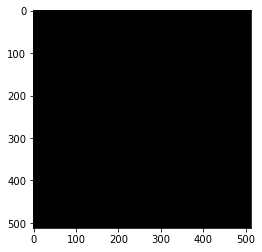

In [15]:
X2, y2 = training_generator_2[20]
print(X2.shape)
print(y2.shape)

X_batch = X2[20,:,:,:]
X_batch.shape
X_img = X_batch[:,:,0]
print(X_img.shape, X_img.max(), X_img.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

In [16]:
model = custom_unet(input_shape=(512,512,1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  144         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 256)  1024       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 64, 64, 128)  131200     ['batch_normalization_9[0][0]']  
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 256)  0           ['conv2d_transpose[0][0]',       
                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_10

In [17]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
filepath = "data_gen_test_2chan.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [18]:
#from new_unet import U_Net
#input_shape = (512,512,1)
#model = U_Net(input_shape)
#model.summary()

In [19]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [20]:
#model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

In [21]:
# Train model on dataset
history = model.fit(training_generator, epochs = 5,
                    validation_data = validation_generator,
                    use_multiprocessing=True,
                    workers=6)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'mul_1' defined at (most recent call last):
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\ipykernel\kernelbase.py", line 381, in dispatch_queue
      yield self.process_one()
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-21-c1a6c7e3b642>", line 2, in <module>
      history = model.fit(training_generator, epochs = 5,
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\metrics.py", line 729, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras_unet\metrics.py", line 41, in dice_coef
      intersection = K.sum(y_true_f * y_pred_f)
Node: 'mul_1'
required broadcastable shapes
	 [[{{node mul_1}}]] [Op:__inference_train_function_4843]

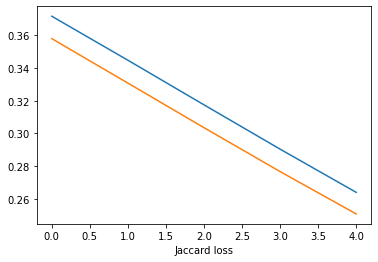

In [39]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

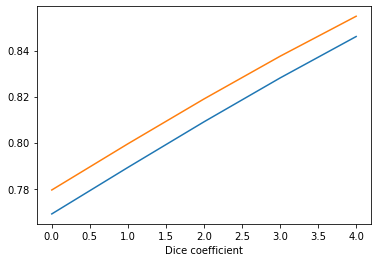

In [40]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

In [41]:
model.save("data_gen_test.h5")

In [42]:
model = custom_unet(input_shape=(512,512,1))
model.load_weights("data_gen_test.h5")

In [45]:
test_img, test_lbl = validation_generator[2]

In [46]:
def visualise_data_and_prediction(x, y, y_pred):
  n=x.shape[-1]
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x, cmap='gray')
    contours = measure.find_contours(y, .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    contours = measure.find_contours(y_pred, .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#35A7FF', lw=4)
    ax.axis('off')

In [49]:
y_pred = model.predict(test_img) #TODO: predict on the training set
y_pred = y_pred.astype('float') 


In [56]:
y_imgs = y_pred[:, :, :, 0]
print(y_imgs.shape)

(12, 512, 512)


In [71]:
y_img_show = y_imgs[2,:,:]
print(y_img_show.shape)
print(y_img_show.min())
print(y_img_show.max())

(512, 512)
0.7465546727180481
0.7465546727180481


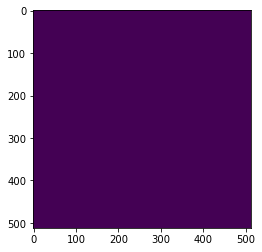

In [60]:
plt.imshow(y_img_show)